In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [2]:
# loading the data from csv file to a Pandas DataFrame
insurance_dataset = pd.read_csv('insurance.csv')

In [3]:
# first 5 rows of the dataframe
insurance_dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# number of rows and columns
insurance_dataset.shape

(1338, 7)

In [5]:
# getting some informations about the dataset
insurance_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
# checking for missing values
insurance_dataset.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
# statistical Measures of the dataset
insurance_dataset.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [8]:
def detect_outliers(df):
    # Initialize summary DataFrame
    summary_df = pd.DataFrame(index=df.columns, columns=['Min', 'Q1', 'Q2 (Median)', 'Q3', 'Max', 'Lower Bound', 'Upper Bound', 'Number of Outliers'])
    
    # Loop through each column
    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:
            # Calculate basic statistics
            min_val = df[column].min()
            Q1 = df[column].quantile(0.25)
            Q2 = df[column].median()
            Q3 = df[column].quantile(0.75)
            max_val = df[column].max()
            
            # Calculate IQR
            IQR = Q3 - Q1
            
            # Calculate lower and upper bounds for outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Count number of outliers
            num_outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
            
            # Store results in summary DataFrame
            summary_df.loc[column] = [min_val, Q1, Q2, Q3, max_val, lower_bound, upper_bound, num_outliers]
        else:
            # Not numeric column, skip outlier detection
            summary_df.loc[column] = [None, None, None, None, None, None, None, None]
    
    return summary_df

detect_outliers(insurance_dataset)

,Min,Q1,Q2 (Median),Q3,Max,Lower Bound,Upper Bound,Number of Outliers
age,18,27.0,39.0,51.0,64,-9.0,87.0,0
sex,None,None,None,None,None,None,None,None
bmi,15.96,26.29625,30.4,34.69375,53.13,13.7,47.29,9
children,0,0.0,1.0,2.0,5,-3.0,5.0,0
smoker,None,None,None,None,None,None,None,None
region,None,None,None,None,None,None,None,None
charges,1121.8739,4740.28715,9382.033,16639.912515,63770.42801,-13109.150897,34489.350562,139


In [9]:
# Replace outliers with the mean of non-outlier values
insurance_dataset['bmi'] = insurance_dataset['bmi'].apply(lambda x: 30.4 if x < 13.7 or x > 47.29 else x)

# Display the DataFrame
insurance_dataset

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


C:\Users\saksh\AppData\Local\Temp\ipykernel_14692\221861118.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(insurance_dataset['age'])


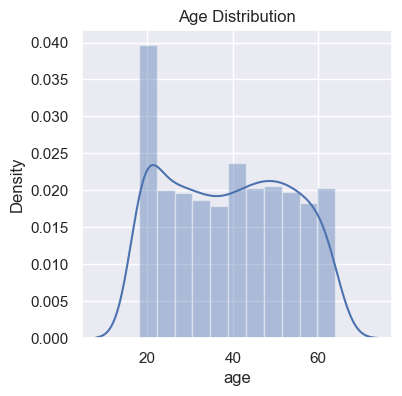

In [10]:
#distribution of age value
sns.set()
plt.figure(figsize=(4,4))
sns.distplot(insurance_dataset['age'])
plt.title('Age Distribution')
plt.show()

In [11]:
insurance_dataset['age'].value_counts()

age
18    69
19    68
50    29
51    29
47    29
46    29
45    29
20    29
48    29
52    29
22    28
49    28
54    28
53    28
21    28
26    28
24    28
25    28
28    28
27    28
23    28
43    27
29    27
30    27
41    27
42    27
44    27
31    27
40    27
32    26
33    26
56    26
34    26
55    26
57    26
37    25
59    25
58    25
36    25
38    25
35    25
39    25
61    23
60    23
63    23
62    23
64    22
Name: count, dtype: int64

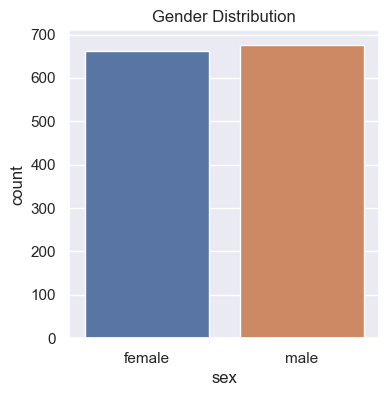

In [12]:
# Gender column
plt.figure(figsize=(4,4))
sns.countplot(x='sex', data=insurance_dataset)
plt.title('Gender Distribution')
plt.show()

In [13]:
insurance_dataset['sex'].value_counts()

sex
male      676
female    662
Name: count, dtype: int64

C:\Users\saksh\AppData\Local\Temp\ipykernel_14692\1075894071.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(insurance_dataset['bmi'])


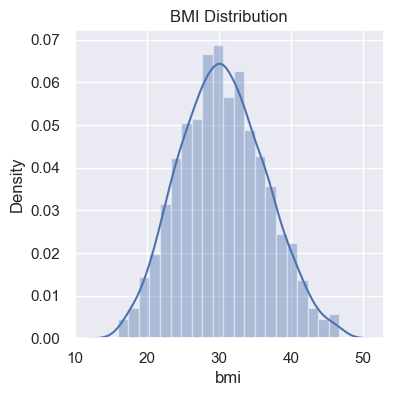

In [14]:
# bmi distribution
plt.figure(figsize=(4,4))
sns.distplot(insurance_dataset['bmi'])
plt.title('BMI Distribution')
plt.show()

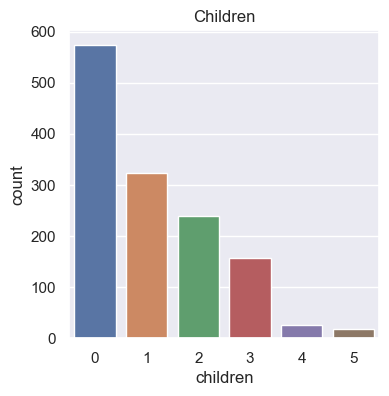

In [15]:
# children column
plt.figure(figsize=(4,4))
sns.countplot(x='children', data=insurance_dataset)
plt.title('Children')
plt.show()

In [16]:
insurance_dataset['children'].value_counts()

children
0    574
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

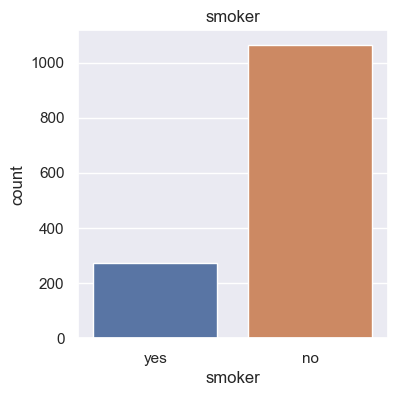

In [17]:
# smoker column
plt.figure(figsize=(4,4))
sns.countplot(x='smoker', data=insurance_dataset)
plt.title('smoker')
plt.show()

In [18]:
insurance_dataset['smoker'].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

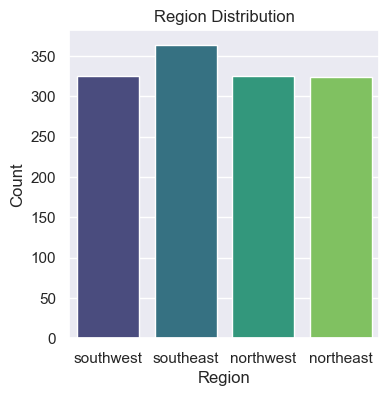

In [19]:
plt.figure(figsize=(4, 4))
sns.countplot(x='region', data=insurance_dataset, palette='viridis')
plt.title('Region Distribution')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()


In [20]:
insurance_dataset['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

C:\Users\saksh\AppData\Local\Temp\ipykernel_14692\1924484256.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(insurance_dataset['charges'])


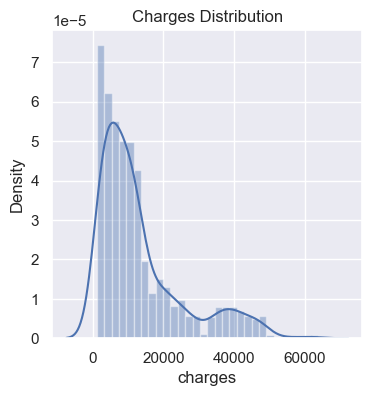

In [21]:
# distribution of charges value
plt.figure(figsize=(4,4))
sns.distplot(insurance_dataset['charges'])
plt.title('Charges Distribution')
plt.show()

In [22]:
# encoding sex column
insurance_dataset.replace({'sex':{'male':0,'female':1}}, inplace=True)

3 # encoding 'smoker' column
insurance_dataset.replace({'smoker':{'yes':0,'no':1}}, inplace=True)

# encoding 'region' column
insurance_dataset.replace({'region':{'southeast':0,'southwest':1,'northeast':2,'northwest':3}}, inplace=True)

In [23]:
X = insurance_dataset.drop(columns='charges', axis=1)
Y = insurance_dataset['charges']

In [24]:
X.head()

,age,sex,bmi,children,smoker,region
0,19,1,27.900,0,0,1
1,18,0,33.770,1,1,0
2,28,0,33.000,3,1,0
3,33,0,22.705,0,1,3
4,32,0,28.880,0,1,3


In [25]:
Y.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2)

print(X.shape, X_train.shape, X_test.shape)

(1338, 6) (936, 6) (402, 6)


In [27]:
from sklearn.preprocessing import StandardScaler 
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
# loading the Linear Regression model
regressor = LinearRegression()

regressor.fit(X_train, Y_train)

LinearRegression()

In [29]:
# Prediction on training data
training_data_prediction = regressor.predict(X_train)

# Prediction on testing data
testing_data_prediction = regressor.predict(X_test)

# Metrics for training data
r2_train = r2_score(Y_train, training_data_prediction)
mae_train = mean_absolute_error(Y_train, training_data_prediction)
mse_train = mean_squared_error(Y_train, training_data_prediction)
rmse_train = np.sqrt(mse_train)
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adjusted_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)

# Metrics for testing data
r2_test = r2_score(Y_test, testing_data_prediction)
mae_test = mean_absolute_error(Y_test, testing_data_prediction)
mse_test = mean_squared_error(Y_test, testing_data_prediction)
rmse_test = np.sqrt(mse_test)
n_test = X_test.shape[0]
p_test = X_test.shape[1]
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

# Create a DataFrame to display the results
metrics = {
    'Metric': ['R squared', 'Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'Adjusted R squared'],
    'Training': [r2_train, mae_train, mse_train, rmse_train, adjusted_r2_train],
    'Testing': [r2_test, mae_test, mse_test, rmse_test, adjusted_r2_test]
}

metrics_df = pd.DataFrame(metrics)
metrics_df


,Metric,Training,Testing
0,R squared,7.375726e-01,7.697092e-01
1,Mean Absolute Error,4.193308e+03,4.157047e+03
2,Mean Squared Error,3.675531e+07,3.722387e+07
3,Root Mean Squared Error,6.062615e+03,6.101137e+03
4,Adjusted R squared,7.358777e-01,7.662111e-01


In [30]:
# Initialize and fit the DecisionTreeRegressor
model_DT = DecisionTreeRegressor(max_depth=5, min_samples_split=2, random_state=42)
model_DT.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [31]:
# prediction on training data
training_data_prediction_DT =model_DT.predict(X_train)

# prediction on test data
testing_data_prediction_DT =model_DT.predict(X_test)

# Metrics for training data
r2_train = r2_score(Y_train, training_data_prediction_DT)
mae_train = mean_absolute_error(Y_train, training_data_prediction_DT)
mse_train = mean_squared_error(Y_train, training_data_prediction_DT)
rmse_train = np.sqrt(mse_train)
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adjusted_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)

# Metrics for testing data
r2_test = r2_score(Y_test, testing_data_prediction_DT)
mae_test = mean_absolute_error(Y_test, testing_data_prediction_DT)
mse_test = mean_squared_error(Y_test, testing_data_prediction_DT)
rmse_test = np.sqrt(mse_test)
n_test = X_test.shape[0]
p_test = X_test.shape[1]
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

# Create a DataFrame to display the results
metrics = {
    'Metric': ['R squared', 'Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'Adjusted R squared'],
    'Training': [r2_train, mae_train, mse_train, rmse_train, adjusted_r2_train],
    'Testing': [r2_test, mae_test, mse_test, rmse_test, adjusted_r2_test]
}

metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Training,Testing
0,R squared,8.761236e-01,8.467797e-01
1,Mean Absolute Error,2.394890e+03,2.688865e+03
2,Mean Squared Error,1.735000e+07,2.476630e+07
3,Root Mean Squared Error,4.165333e+03,4.976575e+03
4,Adjusted R squared,8.753235e-01,8.444523e-01


In [32]:
# Initialize and fit the RandomForestRegressor
model_RF = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42)
model_RF.fit(X_train, Y_train)

RandomForestRegressor(max_depth=5, n_estimators=10, random_state=42)

In [33]:
# prediction on training data
training_data_prediction_RF =model_RF.predict(X_train)

# prediction on test data
testing_data_prediction_RF =model_RF.predict(X_test)

# Metrics for training data
r2_train = r2_score(Y_train, training_data_prediction_RF)
mae_train = mean_absolute_error(Y_train, training_data_prediction_RF)
mse_train = mean_squared_error(Y_train, training_data_prediction_RF)
rmse_train = np.sqrt(mse_train)
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adjusted_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)

# Metrics for testing data
r2_test = r2_score(Y_test, testing_data_prediction_RF)
mae_test = mean_absolute_error(Y_test, testing_data_prediction_RF)
mse_test = mean_squared_error(Y_test, testing_data_prediction_RF)
rmse_test = np.sqrt(mse_test)
n_test = X_test.shape[0]
p_test = X_test.shape[1]
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

# Create a DataFrame to display the results
metrics = {
    'Metric': ['R squared', 'Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'Adjusted R squared'],
    'Training': [r2_train, mae_train, mse_train, rmse_train, adjusted_r2_train],
    'Testing': [r2_test, mae_test, mse_test, rmse_test, adjusted_r2_test]
}

metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Training,Testing
0,R squared,8.843038e-01,8.768590e-01
1,Mean Absolute Error,2.259509e+03,2.429212e+03
2,Mean Squared Error,1.620429e+07,1.990433e+07
3,Root Mean Squared Error,4.025455e+03,4.461427e+03
4,Adjusted R squared,8.835566e-01,8.749885e-01


In [34]:
#Fit KNN Model
model_knn = KNeighborsRegressor(n_neighbors=7)  # Initialize KNN regressor with 5 neighbors
model_knn.fit(X_train, Y_train)

KNeighborsRegressor(n_neighbors=7)

In [35]:
# prediction on training data
training_data_prediction_knn =model_knn.predict(X_train)


# prediction on test data
testing_data_prediction_knn =model_knn.predict(X_test)

# Metrics for training data
r2_train = r2_score(Y_train, training_data_prediction_knn)
mae_train = mean_absolute_error(Y_train, training_data_prediction_knn)
mse_train = mean_squared_error(Y_train, training_data_prediction_knn)
rmse_train = np.sqrt(mse_train)
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adjusted_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)

# Metrics for testing data
r2_test = r2_score(Y_test, testing_data_prediction_knn)
mae_test = mean_absolute_error(Y_test, testing_data_prediction_knn)
mse_test = mean_squared_error(Y_test, testing_data_prediction_knn)
rmse_test = np.sqrt(mse_test)
n_test = X_test.shape[0]
p_test = X_test.shape[1]
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

# Create a DataFrame to display the results
metrics = {
    'Metric': ['R squared', 'Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'Adjusted R squared'],
    'Training': [r2_train, mae_train, mse_train, rmse_train, adjusted_r2_train],
    'Testing': [r2_test, mae_test, mse_test, rmse_test, adjusted_r2_test]
}

metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Training,Testing
0,R squared,8.514300e-01,8.222710e-01
1,Mean Absolute Error,2.774881e+03,3.176807e+03
2,Mean Squared Error,2.080856e+07,2.872786e+07
3,Root Mean Squared Error,4.561640e+03,5.359838e+03
4,Adjusted R squared,8.504704e-01,8.195713e-01


In [36]:
#Fit SVR Model
model_svr = SVR(kernel='linear', C=100)  # Initialize SVR with RBF kernel
model_svr.fit(X_train, Y_train)  

SVR(C=100, kernel='linear')

In [37]:
# prediction on training data
training_data_prediction_svr = model_svr.predict(X_train)

# prediction on test data
testing_data_prediction_svr = model_svr.predict(X_test)

# Metrics for training data
r2_train = r2_score(Y_train, training_data_prediction_svr)
mae_train = mean_absolute_error(Y_train, training_data_prediction_svr)
mse_train = mean_squared_error(Y_train, training_data_prediction_svr)
rmse_train = np.sqrt(mse_train)
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adjusted_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)

# Metrics for testing data
r2_test = r2_score(Y_test, testing_data_prediction_svr)
mae_test = mean_absolute_error(Y_test, testing_data_prediction_svr)
mse_test = mean_squared_error(Y_test, testing_data_prediction_svr)
rmse_test = np.sqrt(mse_test)
n_test = X_test.shape[0]
p_test = X_test.shape[1]
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

# Create a DataFrame to display the results
metrics = {
    'Metric': ['R squared', 'Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'Adjusted R squared'],
    'Training': [r2_train, mae_train, mse_train, rmse_train, adjusted_r2_train],
    'Testing': [r2_test, mae_test, mse_test, rmse_test, adjusted_r2_test]
}

metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Training,Testing
0,R squared,5.986274e-01,6.197340e-01
1,Mean Absolute Error,3.685797e+03,3.759714e+03
2,Mean Squared Error,5.621583e+07,6.146563e+07
3,Root Mean Squared Error,7.497721e+03,7.840002e+03
4,Adjusted R squared,5.960351e-01,6.139578e-01


In [44]:
# Example scores for training and testing R squared
r2_train = [0.74, 0.88, 0.88, 0.85, 0.59]  # Training R2 scores
r2_test = [0.73, 0.84, 0.87, 0.82, 0.62]   # Test R2 scores

models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'KNN', 'SVR']

# Initialize a dictionary to store results
results_dict = {
    'Model': models,
    'Training R squared': r2_train,
    'Testing R squared': r2_test
}

# Create a DataFrame
results_df = pd.DataFrame(results_dict)

# Display the DataFrame
results_df



,Model,Training R squared,Testing R squared
0,Linear Regression,0.74,0.73
1,Decision Tree,0.88,0.84
2,Random Forest,0.88,0.87
3,KNN,0.85,0.82
4,SVR,0.59,0.62


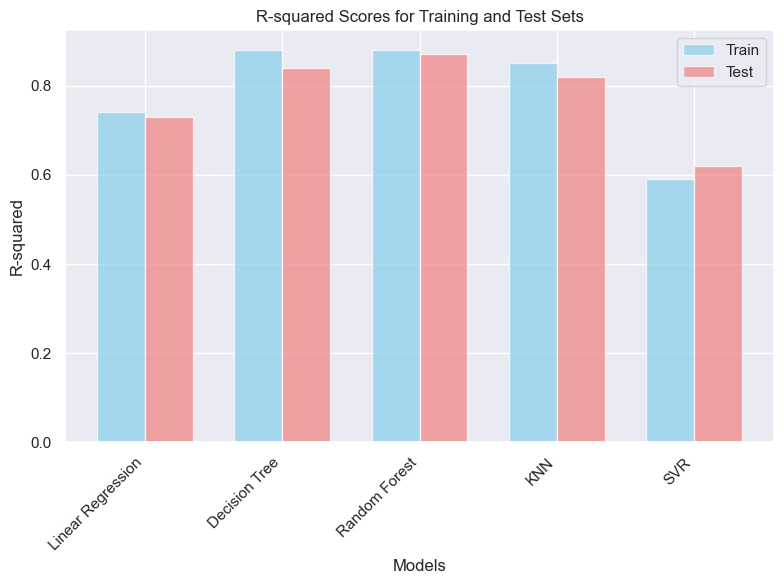

In [45]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.35
index = np.arange(len(models))

bar1 = ax.bar(index, r2_train, bar_width, label='Train', color='skyblue', alpha=0.7)
bar2 = ax.bar(index + bar_width, r2_test, bar_width, label='Test', color='lightcoral', alpha=0.7)

ax.set_xlabel('Models')
ax.set_ylabel('R-squared')
ax.set_title('R-squared Scores for Training and Test Sets')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

In [40]:
# Initialize models and parameter grids
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'KNN': KNeighborsRegressor(),
    'SVR': SVR()
}

param_grids = {
    'Decision Tree': {
        'max_depth': [None] + list(range(1, 15, 1)),
        'min_samples_split': range(2, 11, 2),
        'min_samples_leaf': range(1, 5, 1)
    },
    'Random Forest': {
        'n_estimators': range(1, 15, 4),
        'max_depth': [None] + list(range(1, 15, 1)),
        'min_samples_split': range(2, 11, 3),
        'min_samples_leaf': range(1, 5, 1)
    },
    'KNN': {
        'n_neighbors': range(3, 55, 2),
        
    },
    'SVR': {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto']
    }
}

# Initialize an empty list to store results
results = []

# Loop through each model and perform Grid Search with Cross-Validation
for model_name, model in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, Y_train)
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    
    # Prediction on training data
    training_data_prediction = best_model.predict(X_train)
    
    # Prediction on testing data
    testing_data_prediction = best_model.predict(X_test)
    
    # Metrics for training data
    r2_train = r2_score(Y_train, training_data_prediction)
    mae_train = mean_absolute_error(Y_train, training_data_prediction)
    mse_train = mean_squared_error(Y_train, training_data_prediction)
    rmse_train = np.sqrt(mse_train)
    n_train = X_train.shape[0]
    p_train = X_train.shape[1]
    adjusted_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)
    
    # Metrics for testing data
    r2_test = r2_score(Y_test, testing_data_prediction)
    mae_test = mean_absolute_error(Y_test, testing_data_prediction)
    mse_test = mean_squared_error(Y_test, testing_data_prediction)
    rmse_test = np.sqrt(mse_test)
    n_test = X_test.shape[0]
    p_test = X_test.shape[1]
    adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)
    
     # Append results to the list
    results.append({
        'Model': model_name,
        'Best Parameters': grid_search.best_params_,
        'Training R squared': round(r2_train, 4),
        'Testing R squared': round(r2_test, 4),
        #'Training Mean Squared Error': round(mse_train, 4),
        #'Testing Mean Squared Error': round(mse_test, 4),
        'Training Root Mean Squared Error': round(rmse_train, 4),
        'Testing Root Mean Squared Error': round(rmse_test, 4),
        'Training Adjusted R squared': round(adjusted_r2_train, 4),
        'Testing Adjusted R squared': round(adjusted_r2_test, 4)
    })

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
results_df


Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Fitting 5 folds for each of 26 candidates, totalling 130 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits


,Model,Best Parameters,Training R squared,Testing R squared,Training Root Mean Squared Error,Testing Root Mean Squared Error,Training Adjusted R squared,Testing Adjusted R squared
0,Decision Tree,"{'max_depth': 4, 'min_samples_leaf': 1, 'min_s...",0.8634,0.8528,4373.2340,4877.5418,0.8626,0.8506
1,Random Forest,"{'max_depth': 4, 'min_samples_leaf': 4, 'min_s...",0.8641,0.8755,4363.5153,4485.4494,0.8632,0.8736
2,KNN,{'n_neighbors': 7},0.8514,0.8223,4561.6401,5359.8377,0.8505,0.8196
3,SVR,"{'C': 100, 'gamma': 'scale', 'kernel': 'linear'}",0.5986,0.6197,7497.7214,7840.0021,0.5960,0.6140
